# 3. Feature Extraction, Transformations and Load: 

     En este notebook vamos a recoger los datos de su origen, a darles formato, analizarlos y limpiarlos para poder utilizarlos en nuestros modelos.

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
%matplotlib inline
matplotlib.style.use("ggplot")

In [271]:
pd.set_option('display.max_columns', None)

## 3.1. Data Quality: nans, wrong data, etc.

### 3.1.1. Carga de información y eliminación de información inservible:

     Vamos a utilizar los data sets desde el 2000 hasta el 2016. Creamos un algoritmo que sea capaz de cargar y concatenar todos los archivos a la vez, previo a  empezar la limpieza. 
     
     Los datos de 2017 los utilizaremos al final del proyecto con el algoritmo que hayamos preparado:

In [272]:
import glob

In [273]:
path =r'../tennis_atp-master/Prueba' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
frame = pd.concat(list_)

     Despues de analizar el data set, he detectado datos incorrectos o dudosos en algunas categorías. Aplico el proceso de limpieza que hemos dictaminado como necesario:

In [274]:
# 1. Take out matchs from Davies Cup:
framesD = frame[frame['tourney_level'] != 'D']
# 2. Take out matchs from Challenge CUP:
framesDC = framesD[framesD['tourney_level'] != 'C']
# 3.1. Take out marchs'W/O' (Walk Over):
framesDCWO = framesDC[framesDC['score'] != 'W/O']
# 3.2. Take out marchs' W/O' (Walk Over):
framesDCWO = framesDCWO[framesDCWO['score'] != ' W/O']
# 4. Take out matchs with high volume of NaNs:
framesDCWO2 = framesDCWO.dropna(axis=0, thresh=30)

In [275]:
x = frame.shape
y = framesDCWO2.shape
Limpieza = x[0] - y[0]
Limpieza2 = (float(Limpieza) / float(x[0]))
print "    Hemos eliminado %d partidos sobre un total de %d, lo que supone un %f " %((Limpieza), x[0], (Limpieza2))


    Hemos eliminado 6035 partidos sobre un total de 53120, lo que supone un 0.113611 


     Voy a empezar limpiando el data set de todos aquellos campos que no vamos a utilizar, y creando alguna columna que utilizare en algun momento para crear otras variables.

In [276]:
columns = ['winner_seed', 'loser_seed', 'winner_entry', 'loser_entry']
framesDCWO2.drop(columns, inplace=True, axis=1) 
framesDCWO2['TotalGames'] = framesDCWO2['w_SvGms'] + framesDCWO2['l_SvGms']
framesDCWO2.shape

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



(47085, 46)

### 3.1.2. Completar datos y crear nuevas features:

**i. New Feature creation: Retired**

     Esta variable contempla aquellos partidos que no terminaron. Estos partidos están indicados en score, el campo que contiene el resultado, como retired:

In [277]:
Retired = []
for row in framesDCWO2['score']:
    if 'RET' in row:
        # Append 1
        Retired.append(1)
    # else, if not append 0,
    else:
        Retired.append(0)
# Create a column from the list
framesDCWO2['Retired'] = Retired

/Users/NachoSJ/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [278]:
Ret = framesDCWO2[framesDCWO2['Retired'] == 1 ]
Ret.shape

(1498, 47)

In [279]:
print """     El data set tiene %d partidos no terminados por Retired sobre un total de %d,
   lo que supone un %f""" %(len(Ret.index),len(framesDCWO2.index), (float(len(Ret.index))/float(len(framesDCWO2.index))))

     El data set tiene 1498 partidos no terminados por Retired sobre un total de 47085,
   lo que supone un 0.031815


     Estos partidos seguramente tendran las estadisticas condicionadas. Por tanto debemos quitarlos para evitar que contaminen el resto de partidos.

In [280]:
framesDCWO2 = framesDCWO2[framesDCWO2['Retired'] != 1]
framesDCWO2.shape

(45587, 47)

**ii. New feature creation: Hand** (1 - Right hand, 0 - Left Hand)

In [281]:
Hand = {'R': 1,'L': 0}
framesDCWO2["w_hand"] = np.nan
framesDCWO2["l_hand"] = np.nan
framesDCWO2['w_hand'] = framesDCWO2['w_hand'].fillna(framesDCWO2['winner_hand'].map(Hand))
framesDCWO2['l_hand'] = framesDCWO2['l_hand'].fillna(framesDCWO2['loser_hand'].map(Hand))

     Voy a crear primero todos los pares de features y no haré las diferencias hasta el final. El motivo es que el dataset siempre esta ordenado con winner loser por tanto si aplicara la formula a-b a todo el dataset la Y siempre sería 1, es decir el resultado sería siempre victoria, y el modelo no funcionaria correctamente.
 
     Para solucionar este problema y poder incluir en el modelo partidos con el target 0, voy a aprovechar la simetría de mi modelo. Dividiré el data set en 2 utilizando la lógica siguiente para cada una de las partes:
 
     1 = winner - loser                  
     0 = - winner + loser

    De esta forma voy a obtener un data set con resultados en ambos sentidos

**iii. New feature creation: Best of** (1 - 3 sets, 0 - 5 sets)

In [282]:
Sets = {'5': 1,'3': 0}
framesDCWO2['best_of'] = framesDCWO2['best_of'].astype(str)
framesDCWO2['Total_Sets'] = np.nan
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].fillna(framesDCWO2['best_of'].map(Sets))
framesDCWO2['Total_Sets'] = framesDCWO2['Total_Sets'].astype(int)

**iiii. Solve *_ht (height) problem:**

      Ahora tenemos que hacer un diccionario con todos los *_ht que faltan:

In [283]:
framesDCWO2.isnull().sum()

tourney_id               0
tourney_name             0
surface                  0
draw_size                0
tourney_level            0
tourney_date             0
match_num                0
winner_id                0
winner_name              0
winner_hand              0
winner_ht             1383
winner_ioc               0
winner_age               0
winner_rank            587
winner_rank_points     587
loser_id                 0
loser_name               0
loser_hand               0
loser_ht              2545
loser_ioc                0
loser_age                2
loser_rank             672
loser_rank_points      672
score                    0
best_of                  0
round                    0
minutes               1247
w_ace                    0
w_df                     0
w_svpt                   0
w_1stIn                  0
w_1stWon                 0
w_2ndWon                 0
w_SvGms                  0
w_bpSaved                0
w_bpFaced                0
l_ace                    0
l

In [284]:
w_Names = {'Adrian Cruciat': 185,
 'Alejandro Gonzalez': 191,
 'Aleksandr Nedovyesov': 193,
 'Alexander Zverev': 191,
 'Alexandre Sidorenko': 185,
 'Ante Pavic': 196,
 'Augustin Gensse': 180,
 'Austin Krajicek': 188,
 'Axel Michon': 176,
 'Bastian Knittel': 180,
 'Blaz Rola': 193,
 'Borna Coric': 185,
 'Chris Eaton': 188,
 'Christian Garin': 185,
 'Christian Harrison': 180,
 'Christian Lindell': 193,
 'Chuhan Wang': 188,
 'Daniel Kosakowski': 185,
 'Daniel Munoz De La Nava': 178,
 'Dennis Novikov': 193,
 'Diego Sebastian Schwartzman': 170,
 'Dimitar Kutrovsky': 175,
 'Dominic Thiem': 185,
 'Elias Ymer': 183,
 'Emilio Gomez': 185,
 'Facundo Bagnis': 183,
 'Filip Peliwo': 178,
 'Gianluca Naso': 193,
 'Guido Pella': 185,
 'Guillermo Olaso': 175,
 'Gustavo Marcaccio': 170,
 'Henri Kontinen': 191,
 'Henri Laaksonen': 185,
 'Hiroki Kondo': 178,
 'Hiroki Moriya': 170,
 'Inigo Cervantes Huegun': 183,
 'Ivan Sergeyev': 175,
 'Jamie Baker': 183,
 'Jan Lennard Struff': 196,
 'Jaroslav Pospisil': 178,
 'Jason Kubler': 178,
 'Javier Marti': 185,
 'Jiri Vesely': 198,
 'Joao Sousa': 185,
 'Jonathan Dasnieres De Veigy': 175,
 'Jonathan Marray': 183,
 'Jorge Aguilar': 178,
 'Karen Khachanov': 198,
 'Kyle Edmund': 188,
 'Laurent Recouderc': 178,
 'Leonardo Tavares': 185,
 'Lucas Pouille': 185,
 'Luka Gregorc': 190,
 'Luke Saville': 188,
 'Marco Trungelliti': 180,
 'Martin Alund': 183,
 'Martin Fischer': 180,
 'Marton Fucsovics': 188,
 'Mate Delic': 196,
 'Mate Pavic': 193,
 'Mathieu Rodrigues': 180,
 'Matteo Viola': 185,
 'Maxime Teixeira': 188,
 'Miloslav Mecir': 196,
 'Mirza Basic': 188,
 'Nick Kyrgios': 193,
 'Nikola Milojevic': 188,
 'Nils Langer': 193,
 'Pablo Carreno Busta': 188,
 'Patrik Rosenholm': 178,
 'Pavol Cervenak': 191,
 'Peng Sun': 184,
 'Petar Jelenic': 190,
 'Philip Davydenko': 183,
 'Philipp Oswald': 201,
 'Pierre Hugues Herbert': 188,
 'Pierre Ludovic Duclos': 188,
 'Radu Albot': 175,
 'Rafael Arevalo': 180,
 'Ramkumar Ramanathan': 188,
 'Renzo Olivo': 180,
 'Rhyne Williams': 185,
 'Roberto Bautista Agut': 183,
 'Roberto Carballes Baena': 180,
 'Ruben Bemelmans': 183,
 'Samuel Groth': 193,
 'Sebastian Rieschick': 188,
 'Sergei Bubka': 188,
 'Takahiro Terachi': 174,
 'Taro Daniel': 191,
 'Thanasi Kokkinakis': 196,
 'Tim Puetz': 185,
 'Yan Bai': 185,
 'Yannick Mertens': 188,
 'Yuichi Sugita': 175,
 'Ze Zhang': 188}

In [285]:
framesDCWO2['winner_ht'] = framesDCWO2['winner_ht'].fillna(framesDCWO2['winner_name'].map(w_Names))
framesDCWO2['loser_ht'] = framesDCWO2['loser_ht'].fillna(framesDCWO2['loser_name'].map(w_Names))

**v. Limpiez información:**

    1. Limpiar de NaNs:

In [286]:
framesDCWO2 = framesDCWO2.dropna()

In [287]:
framesDCWO2.isnull().sum()

tourney_id            0
tourney_name          0
surface               0
draw_size             0
tourney_level         0
tourney_date          0
match_num             0
winner_id             0
winner_name           0
winner_hand           0
winner_ht             0
winner_ioc            0
winner_age            0
winner_rank           0
winner_rank_points    0
loser_id              0
loser_name            0
loser_hand            0
loser_ht              0
loser_ioc             0
loser_age             0
loser_rank            0
loser_rank_points     0
score                 0
best_of               0
round                 0
minutes               0
w_ace                 0
w_df                  0
w_svpt                0
w_1stIn               0
w_1stWon              0
w_2ndWon              0
w_SvGms               0
w_bpSaved             0
w_bpFaced             0
l_ace                 0
l_df                  0
l_svpt                0
l_1stIn               0
l_1stWon              0
l_2ndWon        

In [288]:
framesDCWO2.shape

(42629, 50)

    2. Buscar 0 en aquellas variables que puedan tenerlos para evitar generar Infinitos:

In [289]:
framesDCWO2[framesDCWO2['w_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
2005,2009-580,Australian Open,Hard,128,G,20090119,92,103970,David Ferrer,R,175.0,ESP,26.800821,12.0,3390.0,103103,Dominik Hrbaty,R,183.0,SVK,31.041752,251.0,302.0,6-2 6-2 6-1,5,R64,90.0,1.0,0.0,18.0,12.0,11.0,3.0,0.0,0.0,0.0,0.0,0.0,16.0,7.0,4.0,4.0,4.0,0.0,2.0,4.0,0,1.0,1.0,1
414,2006-317,Amersfoort,Clay,32,A,20060717,8,105217,Thiemo De Bakker,R,193.0,NED,17.823409,1055.0,7.0,103898,Julien Benneteau,R,185.0,FRA,24.572211,53.0,711.0,6-3 6-3,3,R32,84.0,3.0,4.0,67.0,28.0,22.0,21.0,0.0,5.0,6.0,2.0,2.0,53.0,36.0,19.0,9.0,0.0,4.0,8.0,0.0,0,1.0,1.0,0


In [290]:
framesDCWO2[framesDCWO2['l_SvGms'] == 0]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,TotalGames,Retired,w_hand,l_hand,Total_Sets
1668,2008-580,Australian Open,Hard,128,G,20080114,49,104053,Andy Roddick,R,188.0,USA,25.374401,6.0,2530.0,104160,Lukas Dlouhy,R,185.0,CZE,24.766598,154.0,275.0,6-3 6-4 7-5,5,R128,98.0,13.0,2.0,89.0,58.0,44.0,18.0,16.0,5.0,7.0,7.0,12.0,88.0,49.0,33.0,16.0,0.0,6.0,11.0,16.0,0,1.0,1.0,1
2446,2011-747,Beijing,Hard,32,A,20111003,9,103344,Ivan Ljubicic,R,193.0,CRO,32.542094,26.0,1375.0,104559,Teymuraz Gabashvili,R,188.0,RUS,26.362765,128.0,432.0,7-5 7-5,3,R32,98.0,14.0,3.0,56.0,37.0,30.0,10.0,12.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0,1.0,1.0,0
2451,2011-747,Beijing,Hard,32,A,20111003,14,103656,Albert Montanes,R,175.0,ESP,30.850103,55.0,825.0,104154,Paul Capdeville,R,190.0,CHI,28.503765,103.0,563.0,6-3 6-3,3,R32,53.0,12.0,1.0,47.0,25.0,24.0,13.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0,1.0,1.0,0
414,2006-317,Amersfoort,Clay,32,A,20060717,8,105217,Thiemo De Bakker,R,193.0,NED,17.823409,1055.0,7.0,103898,Julien Benneteau,R,185.0,FRA,24.572211,53.0,711.0,6-3 6-3,3,R32,84.0,3.0,4.0,67.0,28.0,22.0,21.0,0.0,5.0,6.0,2.0,2.0,53.0,36.0,19.0,9.0,0.0,4.0,8.0,0.0,0,1.0,1.0,0


In [291]:
framesDCWO2 = framesDCWO2.drop(['414','2005','1668','2446','2451'])
framesDCWO2.shape

(42550, 50)

Ahora que tenemos limpio el data set, voy a hacer un ejemplo de visualización, los 50 jugadores mas altos:

In [292]:
tops = framesDCWO2.groupby('winner_name').mean()['winner_ht'].sort_values(ascending=False)
tops = tops.head(50)

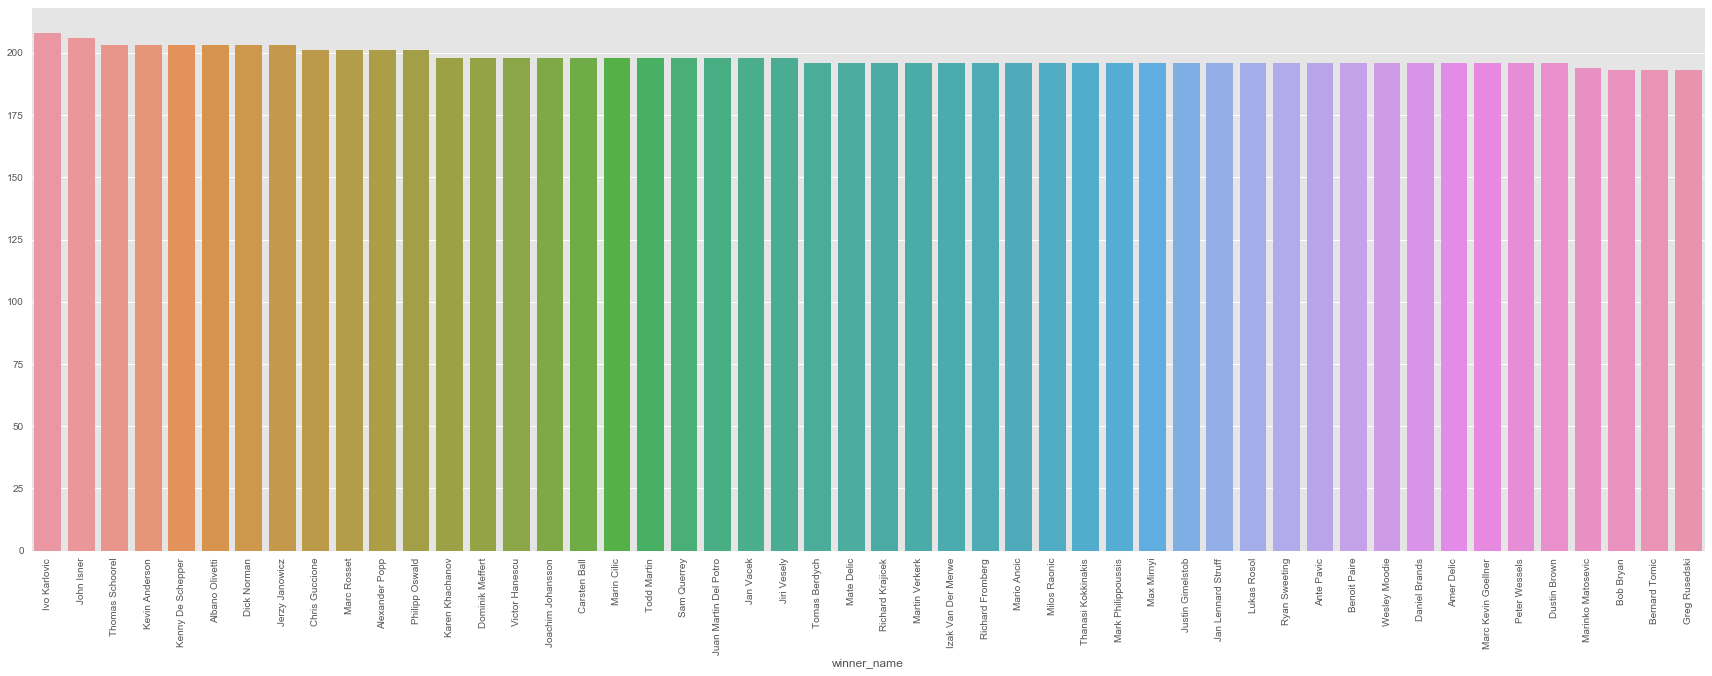

In [293]:
plt.figure(figsize=(30,10))
a=sns.barplot(x=tops.index, y=tops.values)
for item in a.get_xticklabels():
    item.set_rotation(90)

**vi. Average minutes per game:**

     Para poder hacer cualquier iteración lo primero que tenemos que hacer es ordenar cronologicamente, ya que la iteración debe buscar la información en partidos pasados, obviando los partidos ocurridos posteriormente.
     
     Basicamente la iteración buscará en cada partido para ambos jugadores los 'minutes' de todos aquellos partidos (aparezca como winner o loser) pasados. Para hacer la media simplemente sumará todos los minutes y lo dividirá por el total de partidos.

In [294]:
framesDCWO2 = framesDCWO2.sort_values(by=['tourney_date', 'match_num'])

    Ahora ya puedo iterar. En este punto existe la dificultadad de que la duracion del partido va a depender del desarrollo del mismo y además del tipo de torneo que se este jugando, existiendo torneros al mejor de 5 sets y torneos al mejor de 3 sets. Evidentemente la diferencia de tiempo entre uno y otro va a ser importante.
    
    Para solucionar este problema, vamos a convertir el tiempo a tiempo por juego (game), dividiento por el total de juegos obtenido anteriormente.

    Vamos a ordenar el data set:

In [295]:
framesDCWO2 = framesDCWO2.set_index('tourney_date','match_num').sort_index()

    Ahora ya podemos empezar a crear nuestras variables, vamos a acumular los minutes, los juegos y hacer la media. Por último me desaré de las columnas que no necesito:

In [296]:
framesDCWO2['w_minutes_cum']=framesDCWO2.groupby('winner_name')['minutes'].transform(pd.Series.cumsum)
framesDCWO2['w_TotalGames_cum']=framesDCWO2.groupby('winner_name')['TotalGames'].transform(pd.Series.cumsum)
framesDCWO2['w_minutes_average'] = framesDCWO2['w_minutes_cum'] / framesDCWO2['w_TotalGames_cum']
columns = ['w_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

     Hago lo mismo con el loser:

In [297]:
framesDCWO2['l_minutes_cum']=framesDCWO2.groupby('loser_name')['minutes'].transform(pd.Series.cumsum)
framesDCWO2['l_TotalGames_cum']=framesDCWO2.groupby('loser_name')['TotalGames'].transform(pd.Series.cumsum)
framesDCWO2['l_minutes_average'] = framesDCWO2['l_minutes_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['l_minutes_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

**vii. Average aces per game**

In [298]:
framesDCWO2['w_aces_cum']=framesDCWO2.groupby('winner_name')['w_ace'].transform(pd.Series.cumsum)
framesDCWO2['w_aces_average'] = framesDCWO2['w_aces_cum'] / framesDCWO2['w_TotalGames_cum']
framesDCWO2['l_aces_cum']=framesDCWO2.groupby('loser_name')['l_ace'].transform(pd.Series.cumsum)
framesDCWO2['l_aces_average'] = framesDCWO2['l_aces_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['w_aces_cum', 'l_aces_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

**viii. Average double foult per match**

In [299]:
framesDCWO2['w_df_cum']=framesDCWO2.groupby('winner_name')['w_df'].transform(pd.Series.cumsum)
framesDCWO2['w_df_average'] = framesDCWO2['w_df_cum'] / framesDCWO2['w_TotalGames_cum']
framesDCWO2['l_df_cum']=framesDCWO2.groupby('loser_name')['l_df'].transform(pd.Series.cumsum)
framesDCWO2['l_df_average'] = framesDCWO2['l_df_cum'] / framesDCWO2['l_TotalGames_cum']
columns = ['w_df_cum', 'l_df_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

**iv. % First In (w_1stIn/game)**

     Como voy a hacer un ratio, no me interesa saber el numero de partidos. Voy a ir sumando todos los puntos servidos antes de ese partido y todos los 1st in, haciendo el ratio. Si ese ratio se obtuvo en 10 partidos o 1000 no es un factor que vayamos a utilizar.
     
     Tampoco voy a utilizar la ponderacio de partidos a 3 o 5 sets, ya que al ser un ratio el resultado se va a mover siempre en la misma escala, entre 0-1, independientemente de la duración del mismo. Es evidente que si quisieramos ser puristas tendríamos que diferenciarlos porque el rendimiento de un tenista podría variar en los últimos sets por el cansancio o por una estrategia conservadora en los primeos sets.

In [300]:
framesDCWO2['w_1stIn_cum']=framesDCWO2.groupby('winner_name')['w_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['w_SvGames_cum']=framesDCWO2.groupby('winner_name')['w_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['w_1stIn_average'] = framesDCWO2['w_1stIn_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_1stIn_cum']=framesDCWO2.groupby('loser_name')['l_1stIn'].transform(pd.Series.cumsum)
framesDCWO2['l_SvGames_cum']=framesDCWO2.groupby('loser_name')['l_SvGms'].transform(pd.Series.cumsum)
framesDCWO2['l_1stIn_average'] = framesDCWO2['l_1stIn_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_1stIn_cum', 'l_1stIn_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

     De esta forma hacemos un doble estadistico para cadad jugador, uno cuando pierde y otro cuando gana. Conceptualmente hacerlo asi es correcto, porque lo que intentamos es poner etiquetas (ganador/perdedor) sobre los partidos. El mismo jugador tiene unas estadisticas diferentes cuando gana y cuando pierde.

In [301]:
x = framesDCWO2[framesDCWO2['winner_name'] == 'Rafael Nadal']['w_1stIn_average'].mean()
y = framesDCWO2[framesDCWO2['loser_name'] == 'Rafael Nadal']['l_1stIn_average'].mean()
print (x,y)

(4.23555215253495, 4.510577990387127)


**x. % First Won (w_1stWon/game)**

In [302]:
framesDCWO2['w_1stWon_cum']=framesDCWO2.groupby('winner_name')['w_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['w_1stWon_average'] = framesDCWO2['w_1stWon_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_1stWon_cum']=framesDCWO2.groupby('loser_name')['l_1stWon'].transform(pd.Series.cumsum)
framesDCWO2['l_1stWon_average'] = framesDCWO2['l_1stWon_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_1stWon_cum', 'l_1stWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

**xi. % Second Won (w_2ndWon/game)**

In [303]:
framesDCWO2['w_2ndWon_cum']=framesDCWO2.groupby('winner_name')['w_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['w_2ndWon_average'] = framesDCWO2['w_2ndWon_cum'] / framesDCWO2['w_SvGames_cum']
framesDCWO2['l_2ndWon_cum']=framesDCWO2.groupby('loser_name')['l_2ndWon'].transform(pd.Series.cumsum)
framesDCWO2['l_2ndWon_average'] = framesDCWO2['l_2ndWon_cum'] / framesDCWO2['l_SvGames_cum']
columns = ['w_2ndWon_cum', 'l_2ndWon_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

**xii. % Break Point Saved (w_bpSaved/w_bpFaced)**

In [304]:
framesDCWO2['w_bpSaved_cum']=framesDCWO2.groupby('winner_name')['w_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['w_bpFaced_cum']=framesDCWO2.groupby('winner_name')['w_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['w_bpSaved_average'] = framesDCWO2['w_bpSaved_cum'] / framesDCWO2['w_bpFaced_cum']
framesDCWO2['l_bpSaved_cum']=framesDCWO2.groupby('loser_name')['l_bpSaved'].transform(pd.Series.cumsum)
framesDCWO2['l_bpFaced_cum']=framesDCWO2.groupby('loser_name')['l_bpFaced'].transform(pd.Series.cumsum)
framesDCWO2['l_bpSaved_average'] = framesDCWO2['l_bpSaved_cum'] / framesDCWO2['l_bpFaced_cum']
columns = ['w_bpSaved_cum','w_bpFaced_cum', 'l_bpSaved_cum', 'l_bpFaced_cum']
framesDCWO2.drop(columns, inplace=True, axis=1) 

## 3.2. Data Transformation:

#### 1. Creating new Features: Dif

     Tengo listos los estadísticos de cada partido segmentados entre winner y loser. Como comentamos cuando hicimos el estudio inicial del data set, lo que vamos a introducir son las diferencias entre winner/loser para cada feature.
     
     Para poder generar resultados 1 (win) y 0 (lose) tenemos que aplicar las formulas de la siguiente manera:
        1 = w - l
        0 = -w + l
        
     Voy a aplicar cada fórmula a un 50% del dataset. 

In [305]:
framesDCWO2 = framesDCWO2.reset_index()

**i. dif_Minutes**

In [306]:
framesDCWO2['dif_Minutes'] = framesDCWO2['w_minutes_average'] - framesDCWO2['l_minutes_average'] 
framesDCWO2.loc[1::2,'dif_Minutes'] = - framesDCWO2['w_minutes_average'] + framesDCWO2['l_minutes_average'] 

**ii. dif_Aces**

In [307]:
framesDCWO2['dif_Aces'] = framesDCWO2['w_aces_average'] - framesDCWO2['l_aces_average'] 
framesDCWO2.loc[1::2,'dif_Aces'] = - framesDCWO2['w_aces_average'] + framesDCWO2['l_aces_average'] 

**iii. dif_Df**

In [308]:
framesDCWO2['dif_Df'] = framesDCWO2['w_df_average'] - framesDCWO2['l_df_average'] 
framesDCWO2.loc[1::2,'dif_Df'] = - framesDCWO2['w_df_average'] + framesDCWO2['l_df_average'] 

**iv. dif_1stIn**

In [309]:
framesDCWO2['dif_1stIn'] = framesDCWO2['w_1stIn_average'] - framesDCWO2['l_1stIn_average'] 
framesDCWO2.loc[1::2,'dif_1stIn'] = - framesDCWO2['w_1stIn_average'] + framesDCWO2['l_1stIn_average'] 

**v. dif_1stWon**

In [310]:
framesDCWO2['dif_1stWon'] = framesDCWO2['w_1stWon_average'] - framesDCWO2['l_1stWon_average'] 
framesDCWO2.loc[1::2,'dif_1stWon'] = - framesDCWO2['w_1stWon_average'] + framesDCWO2['l_1stWon_average'] 

**vi. dif_2ndWon**

In [311]:
framesDCWO2['dif_2ndWon'] = framesDCWO2['w_2ndWon_average'] - framesDCWO2['l_2ndWon_average'] 
framesDCWO2.loc[1::2,'dif_2ndWon'] = - framesDCWO2['w_2ndWon_average'] + framesDCWO2['l_2ndWon_average'] 

**vii. dif_BpSv**

In [312]:
framesDCWO2['dif_BpSv'] = framesDCWO2['w_bpSaved_average'] - framesDCWO2['l_bpSaved_average'] 
framesDCWO2.loc[1::2,'dif_BpSv'] = - framesDCWO2['w_bpSaved_average'] + framesDCWO2['l_bpSaved_average'] 

Ahora vamos a volver a las primeras variables:

**viii. dif_Age**

In [313]:
framesDCWO2['dif_Age'] = framesDCWO2['winner_age'] - framesDCWO2['loser_age'] 
framesDCWO2.loc[1::2,'dif_Age'] = - framesDCWO2['winner_age'] + framesDCWO2['loser_age'] 

**iv. dif_Height**

In [314]:
framesDCWO2['dif_Height'] = framesDCWO2['winner_ht'] - framesDCWO2['loser_ht'] 
framesDCWO2.loc[1::2,'dif_Height'] = - framesDCWO2['winner_ht'] + framesDCWO2['loser_ht'] 

**x. dif_Rank**

In [315]:
framesDCWO2['dif_Rank'] = framesDCWO2['winner_rank'] - framesDCWO2['loser_rank'] 
framesDCWO2.loc[1::2,'dif_Rank'] = - framesDCWO2['winner_rank'] + framesDCWO2['loser_rank'] 

**xi. dif_RankP**

In [316]:
framesDCWO2['dif_RankP'] = framesDCWO2['winner_rank_points'] - framesDCWO2['loser_rank_points'] 
framesDCWO2.loc[1::2,'dif_RankP'] = - framesDCWO2['winner_rank_points'] + framesDCWO2['loser_rank_points'] 

In [335]:
framesDCWO2.to_csv('framesDCWO2', encoding='utf-8', index=False)

## El otro tipo de estadisticos:
a) Ultimos 5 partidos:

In [317]:
#df["sum4"] = df.groupby("Type")["Value"].apply(lambda x: pd.rolling_sum(x,4))

In [318]:
### Probar doble group by para los últimos 5 partidos

## TARGET:

     Vamos a crear el vector Y siguiendo la lógica aplicada con anterioridad. Las lineas impares contienen victorias (w-l), mientras que las líneas pares contiene derrotas (-w+l). Por tanto, codificaremos como 1 las lineas impares y 0 las lineas pares.

In [319]:
framesDCWO2['Y'] = 1
framesDCWO2.loc[1::2,'Y'] = 0

    Generamos el dataframe definitivo incluyendo todas las features que vamos a utilizar:

In [320]:
TennisDF = framesDCWO2[['Y','dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]             

In [321]:
TennisDF.shape

(42550, 14)

In [322]:
TennisDF = TennisDF.dropna()

In [323]:
TennisDF.shape

(42509, 14)

In [324]:
TennisDF.isnull().sum()

Y              0
dif_Rank       0
dif_RankP      0
dif_Height     0
dif_Age        0
w_hand         0
l_hand         0
dif_Minutes    0
dif_Aces       0
dif_Df         0
dif_1stIn      0
dif_1stWon     0
dif_2ndWon     0
dif_BpSv       0
dtype: int64

**Antes de seguir vamos a hacer una copia de este DataSet. Esta será nuestra base para todos los trabajos posteriores:**

In [325]:
TennisDF.to_csv('TennisDF', encoding='utf-8', index=False)

## 3.3. Data Analisis:

### 3.3.1. Feature distribution:

    Vamos a analizar visualmente la distribución de de nuestras variables:

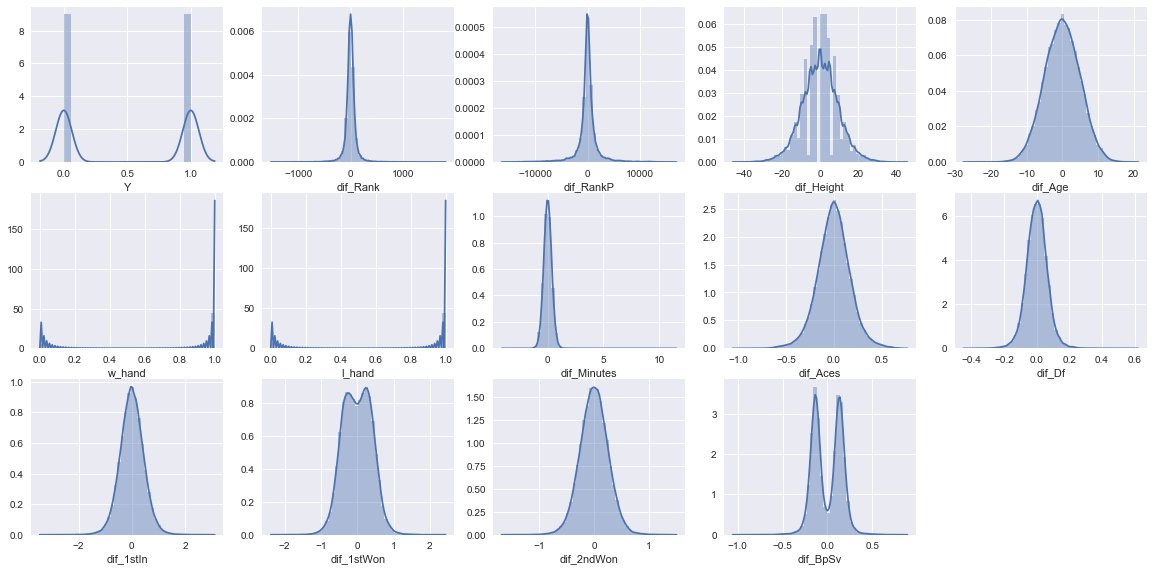

In [326]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
for index,col in enumerate(TennisDF.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDF[col])

     Antes de introducir las variables en el modelo vamos a estandarizarlas:

   **METODO 1:**

     Lo primero que voy a hacer es separar los data sets, en dos, una para los predictores y otro para el target.

In [327]:
TennisDF_X = TennisDF[['dif_Rank','dif_RankP','dif_Height','dif_Age','w_hand','l_hand','dif_Minutes','dif_Aces',
                        'dif_Df','dif_1stIn','dif_1stWon', 'dif_2ndWon','dif_BpSv']]
TennisDF_Y = TennisDF['Y']

     Ahora normalizo las variables predictoras:

In [328]:
TennisDFnorm_X = TennisDF_X.apply(lambda x: (x - np.mean(x)) / (np.std(x)))

In [329]:
TennisDFnorm_X.head()

,dif_Rank,dif_RankP,dif_Height,dif_Age,w_hand,l_hand,dif_Minutes,dif_Aces,dif_Df,dif_1stIn,dif_1stWon,dif_2ndWon,dif_BpSv
0,-0.429112,0.480356,0.845264,-1.907903,0.368448,-2.576821,-0.004915,1.895517,-1.833948,-0.789742,0.001725,-0.230945,0.181169
1,-0.278954,0.634250,0.738884,-1.603764,-2.714087,0.388075,-0.004915,1.009726,3.755639,-0.275683,0.146904,1.047744,-0.319451
2,1.356094,-0.266931,0.738884,0.043516,0.368448,-2.576821,-0.004915,-0.000907,-4.543214,3.741265,2.965791,-1.636733,2.122969
3,0.054729,-0.055915,-0.537676,0.569459,0.368448,0.388075,-0.004915,-0.587074,-3.116080,-1.792722,-2.792965,1.571545,-1.517906
4,-0.087086,0.036610,0.206984,-1.044215,0.368448,0.388075,-0.004915,-0.000907,-5.840609,0.562962,1.589617,2.455458,2.316045


     Vuelvo a visualizar las variables predictoras para ver si están contenidas entre su media y 3 veces su desviación estandar:

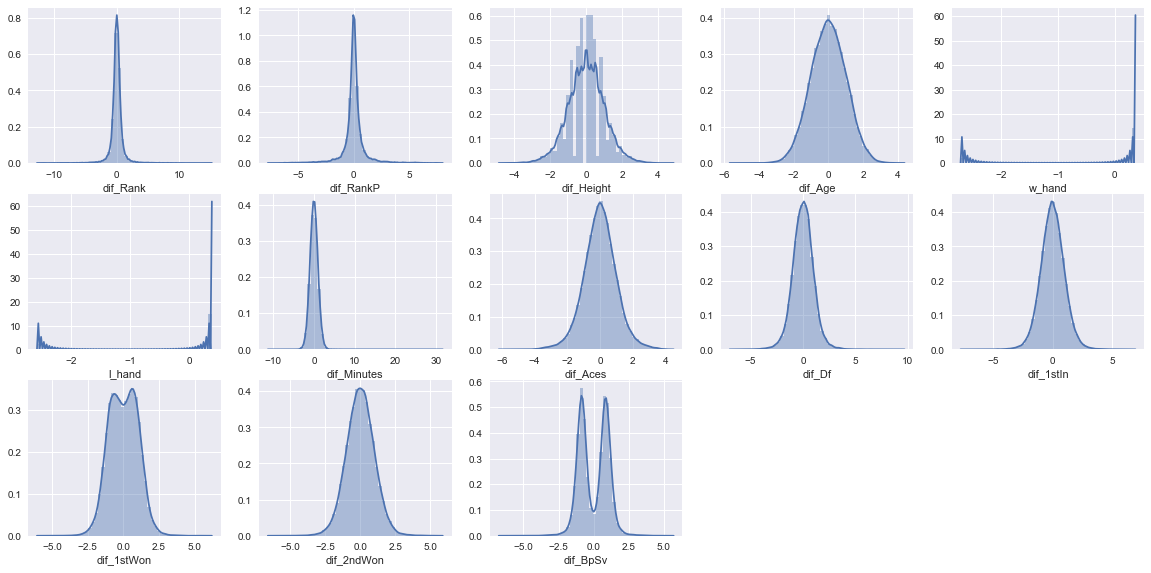

In [330]:
plt.figure(figsize=(20,20))
sns.set(style="darkgrid")
for index,col in enumerate(TennisDFnorm_X.columns):
    plt.subplot(6,5,index+1)
    sns.distplot(TennisDFnorm_X[col])

    Parece que la mayor parte de las variables tienen una distribución normal, con una dispersión contenida.

In [331]:
TennisDFnorm_X['dif_Aces'].std(), TennisDFnorm_X['dif_Aces'].median()

(1.000011762422584, 0.0032719733522802398)

In [332]:
TennisDFnorm_X['dif_Age'].std(), TennisDFnorm_X['dif_Age'].median()

(1.0000117624225726, 0.0015081396382973576)

     Si analizamos por ejemplo dif_Aces o Dif_Age podemos comprobar que la mayor parte de los valores se encuentran contenidos en el intervalo que comprende la mediana y 3 veces su desviación.

     A continuación vamos a hacer una copia del archivo resultante de la normalización, para poder utilizarlo en otros notebooks.

In [333]:
TennisDFnorm_X.to_csv('TennisDFnorm_X', encoding='utf-8', index=False)

In [269]:
#TennisDF[['Y']].to_csv('TennisDF_y', encoding='utf-8', index=False)